In [ ]:
!pip install langgraph langchain langchain_groq langchain_community

In [ ]:
from google.colab import userdata
groq=userdata.get('Groq_key1')

In [ ]:
import os
from typing import Annotated
from typing_extensions import TypedDict

from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_core.prompts import PromptTemplate

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq

In [ ]:
llm=ChatGroq(groq_api_key=groq, model_name="llama-3.1-70b-versatile")

In [ ]:
# State for the graph
class State(TypedDict):
  initial_text : str
  target_language : str
  translated_text : str
  back_translated_text : str
  evaluation_scores : str

In [ ]:
# Translation Chain
translation_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a translation agent. Translate the following {initial_text} from English to {target_language}.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    INITIAL_TEXT: {initial_text}
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["initial_text", "target_language"],
)
translator = translation_prompt | llm | StrOutputParser()

# Back-Translation Chain
back_translation_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a back-translation agent. Translate the following {translated_text} back from {target_language} to English.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    TRANSLATED_TEXT: {translated_text}
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["translated_text", "target_language"],
)
back_translator = back_translation_prompt | llm | StrOutputParser()

# Evaluation Chain
evaluation_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    Evaluate the fidelity of the back-translation against the original text.
    Return the analysis as JSON with one key 'evaluation_score' and no premable or explanation.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    INITIAL_TEXT: {initial_text}
    BACK_TRANSLATED_TEXT: {back_translated_text}
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["initial_text", "back_translated_text"],
)
evaluator = evaluation_prompt | llm | JsonOutputParser()

In [ ]:
# Workflow Nodes
def perform_translation(state):
    print("---TRANSLATING TEXT---")
    print(f"Original Text: {state['initial_text']}")
    initial_text = state['initial_text']
    target_language = state['target_language']

    translated_text = translator.invoke({
        "initial_text": initial_text,
        "target_language": target_language,
    })
    print(translated_text)
    return {"translated_text": translated_text}

def perform_back_translation(state):
    print("---BACK-TRANSLATING TEXT---")
    translated_text = state['translated_text']
    target_language = state['target_language']

    back_translated_text = back_translator.invoke({
        "translated_text": translated_text,
        "target_language": target_language,
    })
    print(back_translated_text)
    return {"back_translated_text": back_translated_text}

def evaluate_translation(state):
    print("---EVALUATING TRANSLATION---")
    initial_text = state['initial_text']
    back_translated_text = state['back_translated_text']

    evaluation_scores = evaluator.invoke({
        "initial_text": initial_text,
        "back_translated_text": back_translated_text,
    })
    print(evaluation_scores)
    return {"evaluation_scores": evaluation_scores}

def summarize_results(state):
    print("---SUMMARIZING RESULTS---")
    summary = {
        "initial_text": state['initial_text'],
        "target_language": state['target_language'],
        "translated_text": state['translated_text'],
        "back_translated_text": state['back_translated_text'],
        "evaluation_scores": state['evaluation_scores'],
    }
    return summary

In [ ]:
workflow = StateGraph(State)

workflow.add_node("perform_translation", perform_translation)
workflow.add_node("perform_back_translation", perform_back_translation)
workflow.add_node("evaluate_translation", evaluate_translation)
workflow.add_node("summarize_results", summarize_results)

workflow.add_edge(START, "perform_translation")
workflow.add_edge("perform_translation", "perform_back_translation")
workflow.add_edge("perform_back_translation", "evaluate_translation")
workflow.add_edge("evaluate_translation", "summarize_results")
workflow.add_edge("summarize_results", END)

graph = workflow.compile()

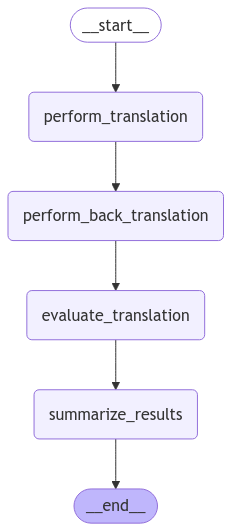

In [ ]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [ ]:
# StateGraph Definition
test_sentence = "I love blue skies and red sunsets"
tgt = "Assamese"
inputs = {"initial_text": test_sentence,"target_language": tgt}

In [ ]:
print(graph.invoke(inputs))

---TRANSLATING TEXT---
Original Text: I love blue skies and red sunsets
মই নীলা আকাশ আৰু ৰঙা সূৰ্যাস্তক ভাল পাওঁ 

(Translation: I love blue skies and red sunsets)

Here's the breakdown:

- I: মই (moi)
- love: ভাল পাওঁ (bhal paon)
- blue: নীলা (neela)
- skies: আকাশ (akax)
- and: আৰু (aru)
- red: ৰঙা (ronga)
- sunsets: সূৰ্যাস্ত (suryast)
---BACK-TRANSLATING TEXT---
I love blue skies and red sunsets
---EVALUATING TRANSLATION---
{'evaluation_score': 1}
---SUMMARIZING RESULTS---
{'initial_text': 'I love blue skies and red sunsets', 'target_language': 'Assamese', 'translated_text': "মই নীলা আকাশ আৰু ৰঙা সূৰ্যাস্তক ভাল পাওঁ \n\n(Translation: I love blue skies and red sunsets)\n\nHere's the breakdown:\n\n- I: মই (moi)\n- love: ভাল পাওঁ (bhal paon)\n- blue: নীলা (neela)\n- skies: আকাশ (akax)\n- and: আৰু (aru)\n- red: ৰঙা (ronga)\n- sunsets: সূৰ্যাস্ত (suryast)", 'back_translated_text': 'I love blue skies and red sunsets', 'evaluation_scores': {'evaluation_score': 1}}
